# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [4]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


In [5]:
# all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
# fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
# nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

# ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
# gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
# nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
# op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
# air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'


all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'



In [6]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,18,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0001   2.392000e+04   1.264448e+08 
    03s34  0019   4.773935e+03   9.463978e-03 
    05s41  0031   4.773194e+03   7.400217e-01 
    06s59  0038   4.772501e+03   4.100327e-09 
Runtime:     06s59
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s01  0005   1.037814e+03   3.817087e+04 
    03s24  0016   8.449549e+02   3.791730e+02 
    05s11  0025   8.445479e+02   5.696279e-08 
Runtime:     05s11
Optimization status: Converged

Optimization restart 2/2, f = 844.547911882
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.932508531294754  |      +ve      |        
  lengthscale  |   4.100329061173523  |      +ve      |        


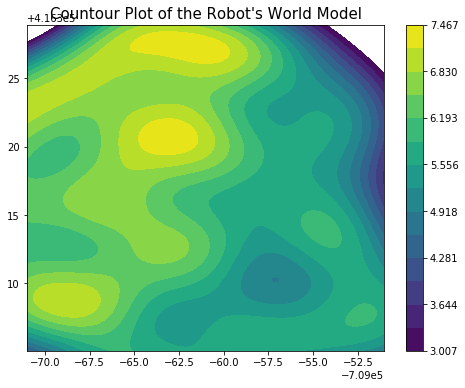

In [18]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

In [ ]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 0.001#12.76#4.10
VAR = np.var(z)#20.47#12.93#

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'mes'
gp_world = GPModel(ranges, 4.10, 12.93)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 12.93, 
                    lengthscale = 4.10, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


(1458, 2) (1458, 1)
19.965 23.853
6.370657765702211 0.3330176189875886
World max value 7.467374396955659 at location [-709064.919  416322.422]
(-709061.0165000001, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709061.0165000001, 416316.99750000006, 0)


 ipp_library.py:611: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:611: RuntimeWarning:invalid value encountered in sqrt
 ipp_library.py:611: RuntimeWarning:invalid value encountered in double_scalars
 ipp_library.py:611: RuntimeWarning:divide by zero encountered in double_scalars


Number of rollouts: 4652 	 Size of tree: 17679
Current predicted max and value: 	[[0. 0.]] 	0.0
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   1.209356e+01   2.534114e+01 
    00s03  0011   3.648348e+00   5.892306e-03 
    00s03  0013   3.340929e+00   4.714983e-04 
    00s05  0018   3.221441e+00   2.078039e-08 
    00s06  0021   3.221414e+00   6.963083e-14 
Runtime:     00s06
Optimization status: Converged

Optimization restart 1/2, f = 3.22141412301
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   1.014399e+01   1.240602e+01 
    00s03  0014   3.295968e+00   2.123061e-04 
    00s05  0020   3.221414e+00   2.616699e-12 
    00s05  0021   3.221414e+00   2.616699e-12 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 3.22141412645
[ 1 ] Current Location:   (-709063.1246392304, 416314.86307994166, 

 ipp_library.py:1649: RuntimeWarning:invalid value encountered in sqrt


Number of rollouts: 3121 	 Size of tree: 9351
Current predicted max and value: 	[-709070.999  416305.071] 	0.0
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   6.503327e+00   3.838283e-11 
Runtime:     00s01
Optimization status: Converged

Optimization restart 1/2, f = 6.50332726858
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0003   1.491802e+01   2.774195e+01 
    00s02  0009   5.112678e+00   2.386710e-02 
    00s03  0012   3.930793e+00   6.580725e-04 
    00s04  0018   3.668110e+00   2.089189e-08 
    00s05  0020   3.668102e+00   1.234599e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 3.66810170018
[ 2 ] Current Location:   (-709060.1246392304, 416314.86307994166, 0.0)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[9.22399348]
Starting global optimization 1 of 2
Max Val

 ipp_library.py:1655: RuntimeWarning:invalid value encountered in divide
 ipp_library.py:1655: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:1655: RuntimeWarning:divide by zero encountered in divide
 ipp_library.py:1655: RuntimeWarning:invalid value encountered in subtract


Number of rollouts: 3212 	 Size of tree: 9128
Current predicted max and value: 	[-709069.62210345  416323.16637931] 	11.801236185987756
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   5.073960e+00   2.843079e-03 
    00s02  0008   4.954580e+00   2.982145e-04 
    00s03  0013   4.952626e+00   1.034292e-12 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 4.95262617449
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   3.232383e+01   2.601961e+01 
    00s02  0008   2.350293e+01   2.509081e+00 

 ipp_library.py:941: RuntimeWarning:invalid value encountered in divide


    00s03  0012   1.722185e+01   1.984324e-02 
    00s04  0016   1.635032e+01   3.665851e-05 
    00s06  0022   9.026572e+00   1.123794e+00 
    00s07  0028   5.614016e+00   1.337045e-02 
    00s08  0031   5.029034e+00   1.165498e-02 
    00s10  0037   4.953706e+00   8.249652e-06 
    00s11  0041   4.952626e+00   1.034273e-11 
Runtime:     00s11
Optimization status: Converged

Optimization restart 2/2, f = 4.95262617594
[ 5 ] Current Location:   (-709061.0242608751, 416319.67685642693, 0.12368421052631584)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[13.98831499]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[13.61455946]
Number of rollouts: 3258 	 Size of tree: 9729
Current predicted max and value: 	[-709065.49141379  416320.69882759] 	5.050843325435387
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   7.560256e+00   1.710859e-03 
    00s02  0007 

    00s00  0003   1.372058e+01   6.427671e-04    00s01  0004   1.372050e+01   1.679192e-06 
    00s03  0011   1.372043e+01   6.422660e-06 
    00s03  0013   1.372043e+01   6.688441e-12 
    00s04  0014   1.372043e+01   6.688441e-12 
Runtime:     00s04
Optimization status: Converged

Optimization restart 1/2, f = 13.720429793
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0009   1.516268e+01   3.554067e-01 
    00s04  0016   1.372043e+01   2.937664e-06 
    00s05  0020   1.372043e+01   8.704771e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 13.7204297938
[ 12 ] Current Location:   (-709057.2270013689, 416310.1185544309, -2.226315789473684)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[12.60497909]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[9.89036392]
Number of rollouts: 774 	 Size of tree: 2585
Current predicted max and value: 	[-709063.42606897  416

    00s00  0001   6.326144e+02   2.212347e+05 
    00s01  0005   1.353287e+02   8.960868e+02 
    00s04  0016   2.298400e+01   2.871778e-01 
    00s05  0021   2.282228e+01   1.597755e-04 
    00s07  0025   2.282226e+01   4.349320e-10 
Runtime:     00s07
Optimization status: Converged

Optimization restart 2/2, f = 22.8222575554
[ 19 ] Current Location:   (-709069.3217756815, 416309.53385678027, -3.8342105263157897)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[7.91195288]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[10.06803793]
Number of rollouts: 752 	 Size of tree: 2519
Current predicted max and value: 	[-709067.55675862  416310.82862069] 	7.364645079159413
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   2.371843e+01   3.251590e-03 
    00s04  0014   2.371236e+01   5.217478e-10 
    00s04  0015   2.371236e+01   5.217478e-10 
Runtime:     00s0

Max Value in Optimization 	 	[9.38091096]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[10.73974705]
few paths available!
few paths available!
few paths available!
few paths available!
few paths available!
Number of rollouts: 755 	 Size of tree: 2547
Current predicted max and value: 	[-709063.42606897  416321.52134483] 	6.992406122902986
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   3.133251e+01   1.043994e+00 
    00s03  0009   3.130464e+01   1.563910e-01 
    00s03  0012   3.129628e+01   8.001627e-04 
    00s05  0016   3.129625e+01   2.507230e-09 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/2, f = 31.2962538883
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   3.191814e+02   1.685393e+04 
    00s03  0012   3.198529e+01   1.833134e-01 
    00s05  0020   3.129626e+01   1.6885

Max Value in Optimization 	 	[9.54489644]
few paths available!
few paths available!
Number of rollouts: 713 	 Size of tree: 2437
Current predicted max and value: 	[-709061.36072414  416327.27896552] 	5.591377525264216
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0011   4.385717e+01   2.392736e-12 
    00s04  0012   4.385717e+01   2.392736e-12 
Runtime:     00s04
Optimization status: Converged

Optimization restart 1/2, f = 43.8571708796
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   4.181408e+02   2.917591e+04 
    00s02  0009   1.710350e+02   2.348370e+02 
    00s06  0019   5.275060e+01   2.355283e+02 
    00s08  0025   4.613851e+01   5.814698e+00 
    00s10  0034   4.480917e+01   1.343032e+01 
    00s12  0041   4.385717e+01   1.188530e-12 
Runtime:     00s12
Optimization status: Converged

Optimization restart 2/2, f = 43.857

Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   1.016271e+02   2.286254e+04 
    00s02  0008   4.575592e+01   8.887436e-04 
    00s05  0015   4.575587e+01   4.326112e-10 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/2, f = 45.7558734076
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   5.875442e+01   6.129229e+01 
    00s03  0010   5.014074e+01   4.423140e+01 
    00s05  0016   4.575819e+01   1.124434e-01 
    00s05  0018   4.575587e+01   5.891450e-05 
    00s06  0020   4.575587e+01   7.942238e-11 
Runtime:     00s06
Optimization status: Converged

Optimization restart 2/2, f = 45.7558734076
[ 41 ] Current Location:   (-709053.0472364501, 416309.36293435795, -8.039473684210526)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[8.28956943]
Starting global optimization 1 of 2
Max Valu

    00s01  0005   4.422525e+01   2.811626e-06 
    00s01  0006   4.422525e+01   2.811626e-06 
Runtime:     00s01
Optimization status: Converged

Optimization restart 1/2, f = 44.2252465934
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   5.689112e+01   1.140506e+03 
    00s03  0013   4.460609e+01   2.379419e-01 
    00s05  0020   4.422524e+01   5.534549e-10 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 44.2252358559
[ 48 ] Current Location:   (-709064.7623975803, 416310.79839353333, -9.894736842105262)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[7.84220064]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[8.49587248]
